In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

from seiz_eeg.dataset import EEGDataset

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [2]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "/home/ogut/data"

DATA_ROOT = Path(data_path)

We have train segments, with labels...

In [3]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
display(clips_tr.iloc[100:115])

label  start_time  end_time       date  \
patient  session   segment                                           
pqejgcpt s002_t001 0            0         0.0      12.0 2003-01-01   
                   1            0        12.0      24.0 2003-01-01   
                   2            0        24.0      36.0 2003-01-01   
                   3            0        36.0      48.0 2003-01-01   
                   4            0        48.0      60.0 2003-01-01   
                   5            0        60.0      72.0 2003-01-01   
                   6            0        72.0      84.0 2003-01-01   
                   7            0        84.0      96.0 2003-01-01   
                   8            0        96.0     108.0 2003-01-01   
                   9            0       108.0     120.0 2003-01-01   
                   10           1       120.0     132.0 2003-01-01   
                   11           1       132.0     144.0 2003-01-01   
                   12           1       144.0     156.0 2003-01-01   
                   13           1       156.0     168.0 2003-01-01   
                   14           1       168.0     180.0 2003-01-01   

                            sampling_rate                        signals_path  
patient  session   segment                                                     
pqejgcpt s002_t001 0                  250  signals/pqejgcpt_s002_t001.parquet  
                   1                  250  signals/pqejgcpt_s002_t001.parquet  
                   2                  250  signals/pqejgcpt_s002_t001.parquet  
                   3                  250  signals/pqejgcpt_s002_t001.parquet  
                   4                  250  signals/pqejgcpt_s002_t001.parquet  
                   5                  250  signals/pqejgcpt_s002_t001.parquet  
                   6                  250  signals/pqejgcpt_s002_t001.parquet  
                   7                  250  signals/pqejgcpt_s002_t001.parquet  
                   8                  250  signals/pqejgcpt_s002_t001.parquet  
                   9                  250  signals/pqejgcpt_s002_t001.parquet  
                   10                 250  signals/pqejgcpt_s002_t001.parquet  
                   11                 250  signals/pqejgcpt_s002_t001.parquet  
                   12                 250  signals/pqejgcpt_s002_t001.parquet  
                   13                 250  signals/pqejgcpt_s002_t001.parquet  
                   14                 250  signals/pqejgcpt_s002_t001.parquet

In [4]:
df = clips_tr.reset_index()
df.describe()

,segment,label,start_time,end_time,date,sampling_rate
count,12993.000000,12993.000000,12993.000000,12993.000000,12993,12993.0
mean,52.965058,0.193720,635.580697,647.580697,2010-05-25 08:04:19.339644416,250.0
min,0.000000,0.000000,0.000000,12.000000,2003-01-01 00:00:00,250.0
25%,19.000000,0.000000,228.000000,240.000000,2008-01-01 00:00:00,250.0
50%,42.000000,0.000000,504.000000,516.000000,2012-01-01 00:00:00,250.0
75%,76.000000,0.000000,912.000000,924.000000,2013-01-01 00:00:00,250.0
max,284.000000,1.000000,3408.000000,3420.000000,2015-01-01 00:00:00,250.0
std,45.404970,0.395227,544.859641,544.859641,NaN,0.0


<AxesSubplot:ylabel='Count'>

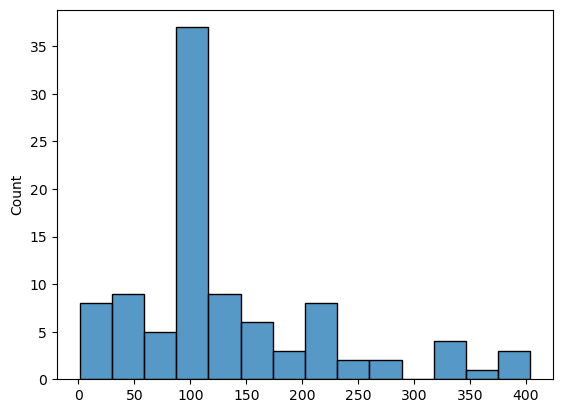

In [5]:
import seaborn as sns

nb_segments_per_patient = df.groupby(by="patient").size().sort_values()
sns.histplot(nb_segments_per_patient)

In [84]:
import seiz_eeg.utils as seiz_utils

def split_train_val(seiz_df, tr_ratio_min, tr_ratio_max, seed=1, print_res=True):
    tr_patients = seiz_utils.patient_split(seiz_df, tr_ratio_min, tr_ratio_max, seed=seed)
    clips_training = seiz_df[seiz_df['patient'].isin(tr_patients)].set_index(["patient", "session", "segment"])
    clips_val = seiz_df[~seiz_df['patient'].isin(tr_patients)].set_index(["patient", "session", "segment"])

    
    if print_res:
        print(f"Length of training data: {len(clips_training)}")
        print(f"Length of validation data: {len(clips_val)}")
        print(f"Ratio training/total: {len(clips_training)/(len(clips_training)+len(clips_val))}")

    return clips_training, clips_val


tr_ratio_min = 0.8
tr_ratio_max = 0.85
seiz_df = clips_tr.reset_index()
seiz2_df = seiz_utils.cut_long_sessions(clips_tr, 4.0)
print(len(clips_tr))
print(len(seiz2_df))
display(seiz2_df.head())

clips_training, clips_val = split_train_val(seiz_df, tr_ratio_min, tr_ratio_max, seed=1, print_res=True)

12993
177


label  start_time  end_time       date  \
patient  session   segment                                           
pqejgcff s001_t000 0            1         0.0       4.0 2003-01-01   
pqejgcpt s002_t001 0            0         0.0       4.0 2003-01-01   
         s003_t001 0            0         0.0       4.0 2003-01-01   
pqejgcsv s001_t000 0            0         0.0       4.0 2003-01-01   
pqejgctq s002_t001 0            1         0.0       4.0 2003-01-01   

                            sampling_rate                        signals_path  
patient  session   segment                                                     
pqejgcff s001_t000 0                  250  signals/pqejgcff_s001_t000.parquet  
pqejgcpt s002_t001 0                  250  signals/pqejgcpt_s002_t001.parquet  
         s003_t001 0                  250  signals/pqejgcpt_s003_t001.parquet  
pqejgcsv s001_t000 0                  250  signals/pqejgcsv_s001_t000.parquet  
pqejgctq s002_t001 0                  250  signals/pqejgctq_s002_t001.parquet

Length of training data: 10665
Length of validation data: 2328
Ratio training/total: 0.8208265989378897


... and test segments, unlabeled.

In [7]:
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet")
display(clips_te.head(10))

start_time  end_time       date  sampling_rate  \
patient  session   segment                                                   
pqejgcvm s001_t000 0               0.0      12.0 2002-01-01            250   
                   1              12.0      24.0 2002-01-01            250   
                   2              24.0      36.0 2002-01-01            250   
                   3              36.0      48.0 2002-01-01            250   
                   4              48.0      60.0 2002-01-01            250   
                   5              60.0      72.0 2002-01-01            250   
                   6              72.0      84.0 2002-01-01            250   
                   7              84.0      96.0 2002-01-01            250   
                   8              96.0     108.0 2002-01-01            250   
                   9             108.0     120.0 2002-01-01            250   

                                                  signals_path  
patient  session   segment                                      
pqejgcvm s001_t000 0        signals/pqejgcvm_s001_t000.parquet  
                   1        signals/pqejgcvm_s001_t000.parquet  
                   2        signals/pqejgcvm_s001_t000.parquet  
                   3        signals/pqejgcvm_s001_t000.parquet  
                   4        signals/pqejgcvm_s001_t000.parquet  
                   5        signals/pqejgcvm_s001_t000.parquet  
                   6        signals/pqejgcvm_s001_t000.parquet  
                   7        signals/pqejgcvm_s001_t000.parquet  
                   8        signals/pqejgcvm_s001_t000.parquet  
                   9        signals/pqejgcvm_s001_t000.parquet

The EEG signals are stored in separate files at the corresponding `signals_path`, and each of them contains all data from a given session. Next section illustrate a convenient interface for loading and iterating on data.

In [8]:
display(
    pd.read_parquet(DATA_ROOT / "train" / clips_tr.iloc[0]["signals_path"]).iloc[
        12000:12015
    ]
)

,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,FZ,CZ,PZ
12000,59.718113,42.933436,14.857250,7.533027,-39.158892,-11.998233,-9.251650,-40.684771,42.933436,-21.458687,33.778158,10.889962,12.415842,11.500314,-28.782910,-25.425974,19.434889,-44.041707,-35.191604
12001,59.942979,44.684182,10.199301,6.537190,-39.544377,-12.994070,-6.585376,-40.154729,43.768654,-20.623469,33.087497,12.640709,14.471764,14.471764,-26.726988,-24.285580,15.082116,-48.089303,-35.882266
12002,63.075048,45.374844,7.533027,7.533027,-45.872762,-11.387881,-9.556825,-39.158892,44.459316,-15.355168,35.304038,15.162426,7.533027,22.791824,-32.750197,-19.932807,14.552074,-50.450401,-38.853716
12003,63.026862,45.326658,11.146953,9.315897,-48.667531,-10.825715,-13.267122,-39.512253,45.021482,-14.487826,34.645500,17.555647,8.095193,25.795398,-34.629438,-19.370641,13.283184,-52.939995,-39.512253
12004,61.227931,45.969134,7.211789,6.906613,-48.025056,-12.014295,-14.150526,-40.395657,47.495013,-15.371230,34.372448,17.282595,13.925660,27.658577,-26.357564,-20.864397,11.179077,-54.738926,-41.311185
12005,58.352852,45.840638,2.505655,5.252239,-48.153551,-13.363494,-12.447966,-42.050032,47.061342,-17.330781,35.769832,18.374804,18.985156,27.530082,-22.823948,-20.077364,11.355757,-53.646718,-41.134504
12006,59.830546,45.792453,5.204053,7.645460,-48.812088,-10.970272,-14.022031,-42.098218,46.707981,-16.768615,36.942351,18.936970,13.138627,32.059536,-28.670476,-20.430726,11.612748,-53.389727,-42.708570
12007,60.970940,45.712143,10.922086,10.311734,-48.892398,-9.829878,-16.848924,-40.957823,46.322495,-15.323045,38.082745,18.551485,9.701382,33.505106,-35.464657,-21.426563,13.668670,-54.385565,-44.619935
12008,58.706214,43.447417,15.981582,8.657360,-45.969134,-10.873901,-16.367067,-42.917374,45.583648,-19.418827,38.259426,14.760878,15.676406,28.798972,-28.879281,-24.911994,15.676406,-53.598532,-42.612198
12009,57.421262,43.993521,11.644871,5.846529,-42.676446,-14.600259,-13.684732,-43.897150,45.214225,-21.619306,39.721058,14.086279,20.189798,25.682965,-23.145186,-24.671065,14.391455,-51.221372,-42.676446


In [53]:
len(pd.read_parquet(DATA_ROOT / "train" / clips_tr.iloc[0]["signals_path"]))/250

1209.0

## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [56]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

In [ ]:
# You can change the signal_transform, or remove it completely
dataset_tr = EEGDataset(
    clips_training,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

dataset_val = EEGDataset(
    clips_val,
    signals_root=DATA_ROOT / "train",
    signal_transform=fft_filtering,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [62]:
# Dependences
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [63]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [64]:
loader_tr = DataLoader(dataset_tr, batch_size=128, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=128, shuffle=True)

In [65]:
for x, y in loader_val:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 3000, 19])
torch.Size([128])


## Baseline: LSTM model for sequential data

In this section, we provide a simple baseline for the project using an LSTM model without any special optimization.

In [66]:
# Define the model
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=19, hidden_dim=64, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, 1)  # Output for binary classification

    def forward(self, x):
        """
        x shape: [batch_size, seq_len, input_dim]
        """
        out, (h_n, c_n) = self.lstm(x)  # out shape: [batch_size, seq_len, hidden_dim]
        last_timestep = out[:, -1, :]  # [batch_size, hidden_dim]
        logits = self.fc(last_timestep)  # [batch_size, 1]
        return logits

In [67]:
from torch.nn import TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
import math

class PositionalEncoding(nn.Module):
    """
    Positional encoding for the transformer model.
    """
    def __init__(self, d_model, max_seq_length=1000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        
        # Register as buffer (not a parameter but part of the module)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape [batch_size, seq_length, feature_dim]
        Returns:
            Output tensor with positional encoding added
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class EEGTransformer(nn.Module):
    """
    Transformer model for EEG binary classification.
    """
    def __init__(
        self,
        input_dim=19,           # Number of EEG channels/features
        d_model=64,             # Embedding dimension
        nhead=8,                # Number of attention heads
        num_encoder_layers=4,   # Number of transformer encoder layers
        dim_feedforward=256,    # Dimension of feedforward network
        dropout=0.1,            # Dropout rate
        max_seq_length=150,     # Maximum sequence length
    ):
        super(EEGTransformer, self).__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        
        self.positional_encoding = PositionalEncoding(
            d_model=d_model,
            max_seq_length=max_seq_length,
            dropout=dropout
        )
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_encoder_layers
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1),
        )
        
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape [batch_size, seq_length, input_dim]
            mask: Optional mask for padding tokens
        Returns:
            Binary classification output
        """
        x = self.input_projection(x)
        x = self.positional_encoding(x)
        x = torch.mean(x, dim=1)
        x = self.classifier(x)
        return x

In [68]:
class EEGClassifier:
    """
    Wrapper class for training and evaluating models.
    """
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    ):
        self.device = device
        
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train_step(self, dataloader, epoch):
        """Train the model for one epoch."""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (sequences, labels) in enumerate(dataloader):
            sequences= sequences.float().to(self.device)
            labels = labels.unsqueeze(1).float().to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(sequences)
            
            loss = self.criterion(outputs, labels)
            
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        return total_loss / len(dataloader), correct / total
    
    def evaluate(self, dataloader):
        """
        Evaluate the model on a dataloader.
        """
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for sequences, labels in dataloader:
                sequences = sequences.float().to(self.device)
                labels = labels.unsqueeze(1).float().to(self.device)
                
                # Forward pass
                outputs = self.model(sequences)
                
                # Calculate loss
                loss = self.criterion(outputs, labels)
                
                # Accumulate metrics
                total_loss += loss.item()
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        return total_loss / len(dataloader), correct / total

In [70]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# model = EEGTransformer(
#     input_dim=19,
#     d_model=32,             
#     nhead=4,               
#     num_encoder_layers=1,   
#     dim_feedforward=128,    
#     dropout=0.0,
#     max_seq_length=1000
# ).to(device)

model = SimpleLSTM(
    input_dim=19,
    hidden_dim=64,
    num_layers=1,
    dropout=0.2
).to(device)


loader_tr = DataLoader(dataset_tr, batch_size=16, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=16, shuffle=True)

num_samples = len(dataset_tr)
num_class_1 = sum([sum(label) for _, label in loader_tr])
num_class_0 = num_samples - num_class_1

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([num_class_0/num_class_1]).to(device))

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.001)

In [72]:
total_params = sum(p.numel() for p in model.parameters())
total_params

55105

In [ ]:
# train_dataset = SampleEEGDataset(num_samples=50)
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# test_dataset = SampleEEGDataset(num_samples=20, seed=43)
# test_dataloader = DataLoader(test_dataset, batch_size=16)

train_losses = []
eval_losses = []

train_accs = []
eval_accs = []

# Initialize the classifier
classifier = EEGClassifier(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

# Train the model
num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    train_loss, train_acc = classifier.train_step(loader_tr, epoch)    
    # Evaluate on test set
    test_loss, test_acc = classifier.evaluate(loader_val)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    eval_losses.append(test_loss)
    eval_accs.append(test_acc)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [09:12<00:00, 11.05s/it]


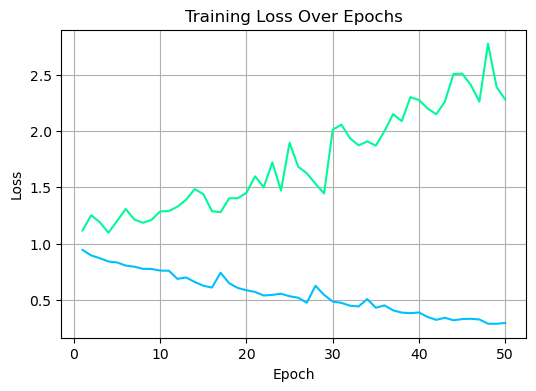

In [75]:
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, color="deepskyblue")
plt.plot(range(1, len(eval_losses) + 1), eval_losses, color="mediumspringgreen")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

0.7873711340206185


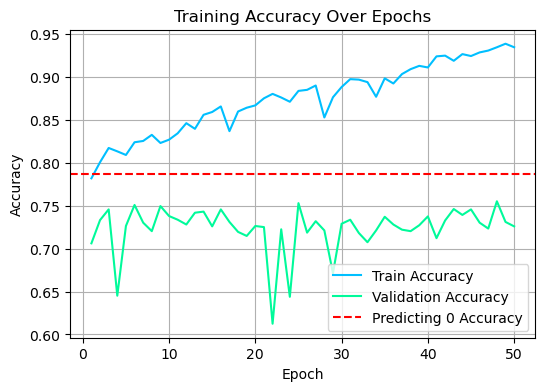

In [76]:
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_accs) + 1), train_accs, color="deepskyblue", label="Train Accuracy")
plt.plot(range(1, len(eval_accs) + 1), eval_accs, color="mediumspringgreen", label="Validation Accuracy")

num_samples = len(dataset_val)
num_class_1 = sum([sum(label) for _, label in loader_val])
num_class_0 = num_samples - num_class_1

accuracy_predicting_0 = num_class_0.item() / num_samples
print(accuracy_predicting_0)
plt.axhline(y=accuracy_predicting_0, color="red", linestyle="--", label="Predicting 0 Accuracy")

plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Submission

In [ ]:
# Create test dataset
dataset_te = EEGDataset(
    clips_te,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    signal_transform=fft_filtering,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [ ]:
# Generate the submission file for Kaggle

# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in loader_te:
        # Assume each batch returns a tuple (x_batch, sample_id)
        # If your dataset does not provide IDs, you can generate them based on the batch index.
        x_batch, x_ids = batch

        # Move the input data to the device (GPU or CPU)
        x_batch = x_batch.float().to(device)

        # Perform the forward pass to get the model's output logits
        logits = model(x_batch)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        predictions = (logits > 0).int().cpu().numpy()

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(x_ids))

# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})

# Save the DataFrame to a CSV file without an index
submission_df.to_csv("submission_seed1.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
